In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr

import itertools

from py_wake.deficit_models import EddyViscosityDeficitModel, EddyViscosityModel
from py_wake import HorizontalGrid

# turbines and sites
from py_wake.site import XRSite, UniformWeibullSite
from py_wake.site._site import Site
from py_wake.site.shear import PowerShear
from py_wake.wind_turbines import WindTurbine
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite
from py_wake.examples.data.dtu10mw import DTU10MW

from py_wake.wind_farm_models.wind_farm_model import SimulationResult
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
INPUT_TENSORS_FILEPATH = "data/input_tensors.pt"
WS_OUTPUT_TENSORS_FILEPATH = "data/WS_output_tensors.pt"
TI_OUTPUT_TENSORS_FILEPATH = "data/TI_output_tensors.pt"

# Preparation of the parameters for the data generation

## Site (to set turbulence intensity TI and...?)
For a given position, reference wind speed (WSref) and wind direction (WDref), Site provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, Site is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

In [4]:
# TODO decide what site to use (custom or predefined) and see how to set other parameters (P, shear, dataset, etc. etc.)
def get_sites(turbulence_intensity : float) -> list[XRSite]:

    # assert 0 <= turbulence_intensity <= 1 #TODO if it is a percentage, this is correct

    custom_site = UniformWeibullSite(
        p_wd = [.20,.25,.35,.25],                         # sector frequencies
        a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parameter
        k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parameter
        ti = turbulence_intensity,                        # turbulence intensity, optional
    )
    '''
    not working
    custom_site = XRSite(
        ds=xr.Dataset(data_vars={'WS': range(3, 26), 'P': ('wd', [1/360] * len(range(0, 360))), 'TI': 0.25},
                    coords={'wd': range(0, 360)}),
        shear=PowerShear(h_ref=100, alpha=.2)
    )
    '''
    return [IEA37Site(ti=turbulence_intensity), Hornsrev1Site(ti=turbulence_intensity), custom_site] #ParqueFicticioSite() not having ti as an argument

## Turbine (to set thrust coefficient CT)

For a given wind turbine type and effective wind speed (WSeff), the WindTurbine object provides the power and thrust coefficient (CT), as well as the wind turbine hub height (H) and diameter (D).

In [5]:
# TODO decide what turbine(s) to use (custom or predefined) and see how to set other parameters

def get_wind_turbines(u: list[int] = [5, 10, 15, 20, 25],
                      power: list[float] = [0, 0, 0, 0, 0], #####
                      ct: list[float] = [0.99, 0.5, 0.75, .3, 0.9]) -> list[WindTurbine]:
    # you need 3 parameters for a custom turbine: u (ws_values), power and ct curves
    # (see how powerCtFunction is initialized in the pre-defined turbines)
    custom_turbine = WindTurbine(name="custom", diameter=80, hub_height=321, powerCtFunction=PowerCtTabular(u, power,'kW', ct))

    return [V80(), IEA37_WindTurbines(), DTU10MW()]  #, custom_turbine] 

def plot_ct_curves(custom_turbine) -> None:
    # plot Ct curve
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('CT [-]')

    wts = WindTurbines.from_WindTurbine_lst([V80(), IEA37_WindTurbines(), DTU10MW(), custom_turbine])
    ws = np.arange(3,25)
    for t in wts.types():
        plt.plot(ws, wts.ct(ws, type=t),'.-', label=wts.name(t))
    plt.legend(loc=1)

## Other parameters

In [6]:
TURBINE_X = [0]
TURBINE_Y = [0]

def get_discretized_grid(diameter: int) -> HorizontalGrid: #TODO decide whether this function should depend on the diameter or not
    # TODO check the discretization (see Javier thesis, appendix B in particular), my current reasonings:
    # for the minimum length is diameter*2 to skip the near-wake, but TODO this depends also on the wind direction
    #   i.e. if the wind direction is within the whole range (0, 360), there will be some warnings of near-wake region even if I set diameter*2
    # for the maximum length is diameter*50 (i.e. DEFAULT_MAXIMUM_WAKE_DISTANCE in PyWake EddyViscosity definition) ✅
    # for the third value (?), Javier's thesis tries different values (diameter/2, diameter/4, ..., diameter/16)
    
    # if the wind direction remains stable at 270 (as it seems), it is useless to put a big grid for y
    x_range = np.arange(diameter*2, diameter*50, diameter/4)
    x_range = np.arange(-diameter*2, diameter*50, diameter/16) #TODO remove (only for attempts)
    y_range = np.arange(-diameter*2, diameter*2, diameter/16)
    return HorizontalGrid(x = x_range, y = y_range)

WS_RANGE = range(10, 26) # by default, 3-25 m/s in bins of 1 m/s TODO change (also the binning)
WD_RANGE = 270 # the wind turbine's yaw angle is always adjusted according to the wind direction, thus it is probably useless to generate data with more wind directions
#WD_RANGE = range(0, 360) # (by default, 0-360° in bins of 1°)

# Boh

In [7]:
def generate_wake_fields(sim_res, grid: HorizontalGrid, wind_speed : float, wind_direction : int = WD_RANGE, with_plot : bool = False) -> tuple[torch.Tensor, torch.Tensor]:
    #TODO the following method call (flow_map) creates a warning because the Ainslie model cannot be applied to the near-wake zone
    flow_map = sim_res.flow_map(grid=grid,
                                wd=wind_direction,
                                ws=wind_speed)
    if with_plot:
        plot_flow_map(flow_map)

    # removing h, wd and ws
    h = flow_map['h'].item()
    flow_map = flow_map\
        .sel(h=h)\
        .sel(wd=wind_direction)\
        .sel(ws=wind_speed)
    flow_map = flow_map.drop_vars(["h", "wd", "ws"])
    
    # wake fields
    WS_eff_field = flow_map.WS_eff # 2d array
    TI_eff_field = flow_map.TI_eff # 2d array

    WS_eff_output = torch.from_numpy(WS_eff_field.to_numpy().flatten()) # 1d tensor
    TI_eff_output = torch.from_numpy(TI_eff_field.to_numpy().flatten()) # 1d tensor
    return WS_eff_output, TI_eff_output

def plot_flow_map(flow_map):
    plt.figure()
    flow_map.plot_wake_map()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Wake map')

# Actual data generation

EddyViscosityModel(PropagateDownwind, EddyViscosityDeficitModel-wake, MaxSum-superposition, ModifiedQuartonAndAinslieTurbulenceModel-turbulence)


/Users/niccolomorabito/Desktop/PyWake/py_wake/deficit_models/eddy_viscosity.py:202: UserWarning: the Eddy Viscosity wake model is not appropriate for turbine spacings less than two rotor diameters; the solution at two rotor diameters was used for smaller distances
  warnings.warn(


0.72

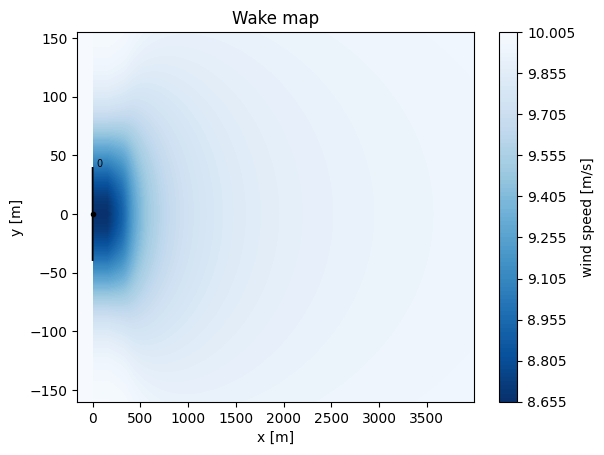

In [51]:
sites = get_sites(turbulence_intensity=0.72)
wind_turbines = get_wind_turbines()

for site, wind_turbine in itertools.product(sites, wind_turbines):
    # single wake model
    ainslie_model = EddyViscosityModel(site, wind_turbine)
    print(ainslie_model)

    diameter: int = wind_turbine.diameter().item() #TODO this needs to be used for scaling distances and also to exclude near-wake region
    horizontal_grid = get_discretized_grid(diameter)

    sim_res: SimulationResult = ainslie_model(
        TURBINE_X, TURBINE_Y,        # wind turbine positions (setting also wt domain, i.e. the number of turbines)
        h=None,                      # wind turbine heights (defaults to the heights defined in windTurbines)
        type=0,                      # Wind turbine types
        wd=WD_RANGE,                 # Wind direction (None for default -> 0-360° in bins of 1°)
        ws=WS_RANGE,                 # Wind speed (None for default -> 3-25 m/s in bins of 1 m/s)
        #TI = 0.15 # DO NOT SET TI HERE, this is not taken into account when calling flow_map (TI depends on the chosen site)
    ) # type: ignore

    for wind_speed in WS_RANGE:
        ct = wind_turbine.ct(ws=wind_speed)
        TI = sim_res.TI.item()
        input_tensor = torch.FloatTensor([wind_speed, ct, TI]) #TODO add other input features
        WS_eff_output, TI_eff_output = generate_wake_fields(sim_res, horizontal_grid, wind_speed=wind_speed, with_plot=True)
        break
    break #TODO

In [72]:
# QUESTO DEVE DIVENTARE IL NUOVO METODO generate_wake_fields
datasets = []
for wind_speed in WS_RANGE:
    flow_map = sim_res.flow_map(grid=horizontal_grid,
                                wd=270,
                                ws=wind_speed)

    # removing h, wd and ws
    h = flow_map['h'].item()
    flow_map = flow_map\
        .sel(h=h)\
        .sel(wd=270)\
        #.expand_dims({"ti": 1})
        #.assign_coords({"ti": 0.72})
        #.sel(ws=wind_speed)
    flow_map["ti"] = xr.DataArray([0.72], dims="ti")
    flow_map = flow_map.drop_vars(["h", "wd", "WD", "WS", "TI"])

    datasets.append(flow_map)

    # how to plot a xarray #
    #ds = xr.Dataset.from_dataframe(flow_map.to_dataframe())
    #ds.WS_eff.plot()
    ########################

xr.merge(datasets).to_dataframe()

/Users/niccolomorabito/Desktop/PyWake/py_wake/deficit_models/eddy_viscosity.py:202: UserWarning: the Eddy Viscosity wake model is not appropriate for turbine spacings less than two rotor diameters; the solution at two rotor diameters was used for smaller distances
  warnings.warn(
/Users/niccolomorabito/Desktop/PyWake/py_wake/deficit_models/eddy_viscosity.py:202: UserWarning: the Eddy Viscosity wake model is not appropriate for turbine spacings less than two rotor diameters; the solution at two rotor diameters was used for smaller distances
  warnings.warn(
/Users/niccolomorabito/Desktop/PyWake/py_wake/deficit_models/eddy_viscosity.py:202: UserWarning: the Eddy Viscosity wake model is not appropriate for turbine spacings less than two rotor diameters; the solution at two rotor diameters was used for smaller distances
  warnings.warn(
/Users/niccolomorabito/Desktop/PyWake/py_wake/deficit_models/eddy_viscosity.py:202: UserWarning: the Eddy Viscosity wake model is not appropriate for turb

WS_eff  TI_eff      P
x       y      ws ti                         
-160.0  -160.0 10 0.72    10.0    0.72  3.408
               11 0.72    11.0    0.72  3.408
               12 0.72    12.0    0.72  3.408
               13 0.72    13.0    0.72  3.408
               14 0.72    14.0    0.72  3.408
...                        ...     ...    ...
 3995.0  155.0 21 0.72    21.0    0.72  3.408
               22 0.72    22.0    0.72  3.408
               23 0.72    23.0    0.72  3.408
               24 0.72    24.0    0.72  3.408
               25 0.72    25.0    0.72  3.408

[851968 rows x 3 columns]

In [28]:
"""
input_tensors = list()
WS_output_tensors = list()
TI_output_tensors = list()

for wind_speed, wind_direction in itertools.product(WS_RANGE, WD_RANGE):
    # input parameters
    ct = wind_turbine.ct(ws=wind_speed) #TODO change turbine to modify ct
    input_tensor = torch.FloatTensor([wind_speed, wind_direction, ct]) #TODO TI missing
    input_tensors.append(input_tensor)

    WS_eff_output, TI_eff_output = generate_wake_fields(wind_direction, wind_speed)
    WS_output_tensors.append(WS_eff_output)
    TI_output_tensors.append(TI_eff_output)

print(len(input_tensors), len(WS_output_tensors), len(TI_output_tensors))
torch.save(input_tensors, INPUT_TENSORS_FILEPATH)
torch.save(WS_output_tensors, WS_OUTPUT_TENSORS_FILEPATH)
torch.save(TI_output_tensors, TI_OUTPUT_TENSORS_FILEPATH)
"""

'\ninput_tensors = list()\nWS_output_tensors = list()\nTI_output_tensors = list()\n\nfor wind_speed, wind_direction in itertools.product(WS_RANGE, WD_RANGE):\n    # input parameters\n    ct = wind_turbine.ct(ws=wind_speed) #TODO change turbine to modify ct\n    input_tensor = torch.FloatTensor([wind_speed, wind_direction, ct]) #TODO TI missing\n    input_tensors.append(input_tensor)\n\n    WS_eff_output, TI_eff_output = generate_wake_fields(wind_direction, wind_speed)\n    WS_output_tensors.append(WS_eff_output)\n    TI_output_tensors.append(TI_eff_output)\n\nprint(len(input_tensors), len(WS_output_tensors), len(TI_output_tensors))\ntorch.save(input_tensors, INPUT_TENSORS_FILEPATH)\ntorch.save(WS_output_tensors, WS_OUTPUT_TENSORS_FILEPATH)\ntorch.save(TI_output_tensors, TI_OUTPUT_TENSORS_FILEPATH)\n'